In [1]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

In [2]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [5]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [4]:
filename = "2023913_1110.h5"
#filename = "2023811_1451.h5"
spectrum, wavelengths, exp_properties = Raman_data_loader(filename)

In [18]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [19]:
lam = 1e2
p = 1e-1

pro_data = 1*spectrum
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [09:23<00:00,  2.25s/it]


In [20]:
spectrum=pro_data

In [21]:
spe = spectrum.reshape(spectrum.shape[0]*spectrum.shape[1], -1)
norm = np.array([gaussian_filter(spe[i, :]/np.sum(spe[i, :]), sigma = 0) for i in range(0, spe.shape[0])]).reshape(spectrum.shape)

In [22]:
norm_for_pca = norm.reshape(norm.shape[0]*norm.shape[1], -1)
norm_for_pca.shape

(25000, 1024)

In [23]:
s = norm.min()
b = norm.max()


scaled_pro = np.array([(norm[:, :, wv] - s)/(b - s) 
                       for wv in tqdm(range(norm.shape[-1]))])

100%|████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 1245.51it/s]


In [24]:
scaled_for_pca = scaled_pro.reshape(scaled_pro.shape[0], -1).T
scaled_for_pca.shape

(25000, 1024)

# Decomposition

### Test for the number of components

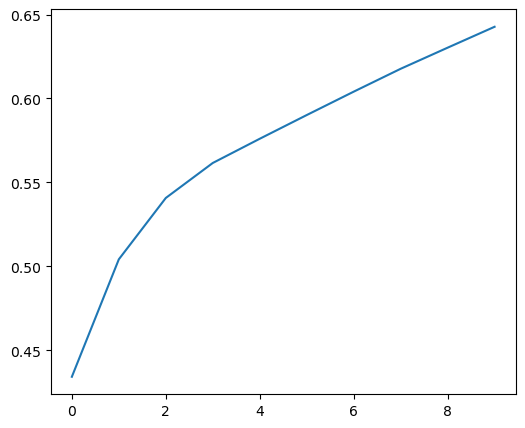

In [32]:
model = sklearn.decomposition.PCA(n_components = 10)
model.fit(norm_for_pca)

fig, ax = subplots(figsize = (6, 5))
ax.plot(np.cumsum(model.explained_variance_ratio_)) # above 5 components more than 95% of the variance is explained

### Decompose dataset

In [33]:
model_basis = sklearn.decomposition.PCA(n_components = 6)
model_basis.fit(scaled_for_pca)

PCA(n_components=6)

In [27]:
principal_components = model_basis.fit_transform(scaled_for_pca)
weigths = model_basis.components_
mu = np.mean(scaled_for_pca, axis = 0)

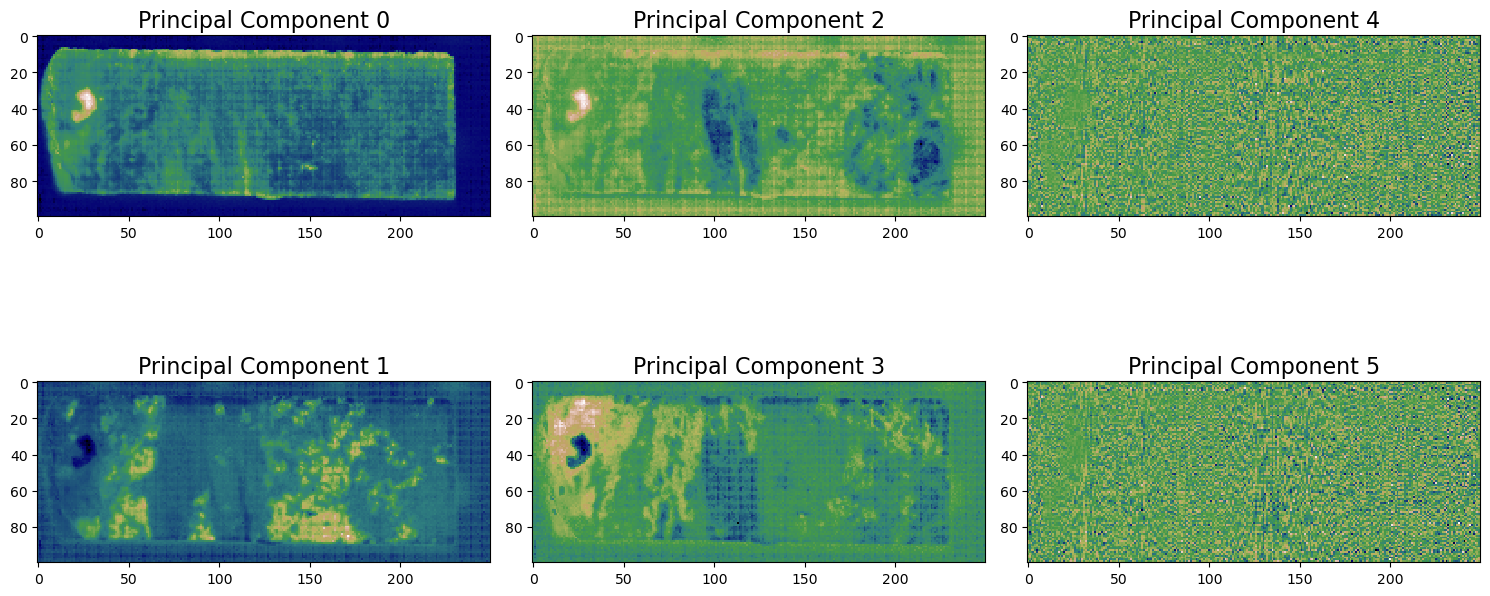

In [28]:
principal_images = principal_components.reshape(spectrum.shape[0], spectrum.shape[1], principal_components.shape[-1])

fig, ax = subplots(2, 3, figsize = (15, 8))

h, v = 0, 0

for i in range(principal_components.shape[-1]):
    axs = ax[h, v]
    axs.imshow(principal_images[:, :, i].T, cmap = 'gist_earth', interpolation = 'nearest')
    axs.set_title(f'Principal Component {i}', fontsize = 16)
    axs.grid(False)
    
    h += 1
    if h == 2:
        v += 1
        h = 0

fig.tight_layout()

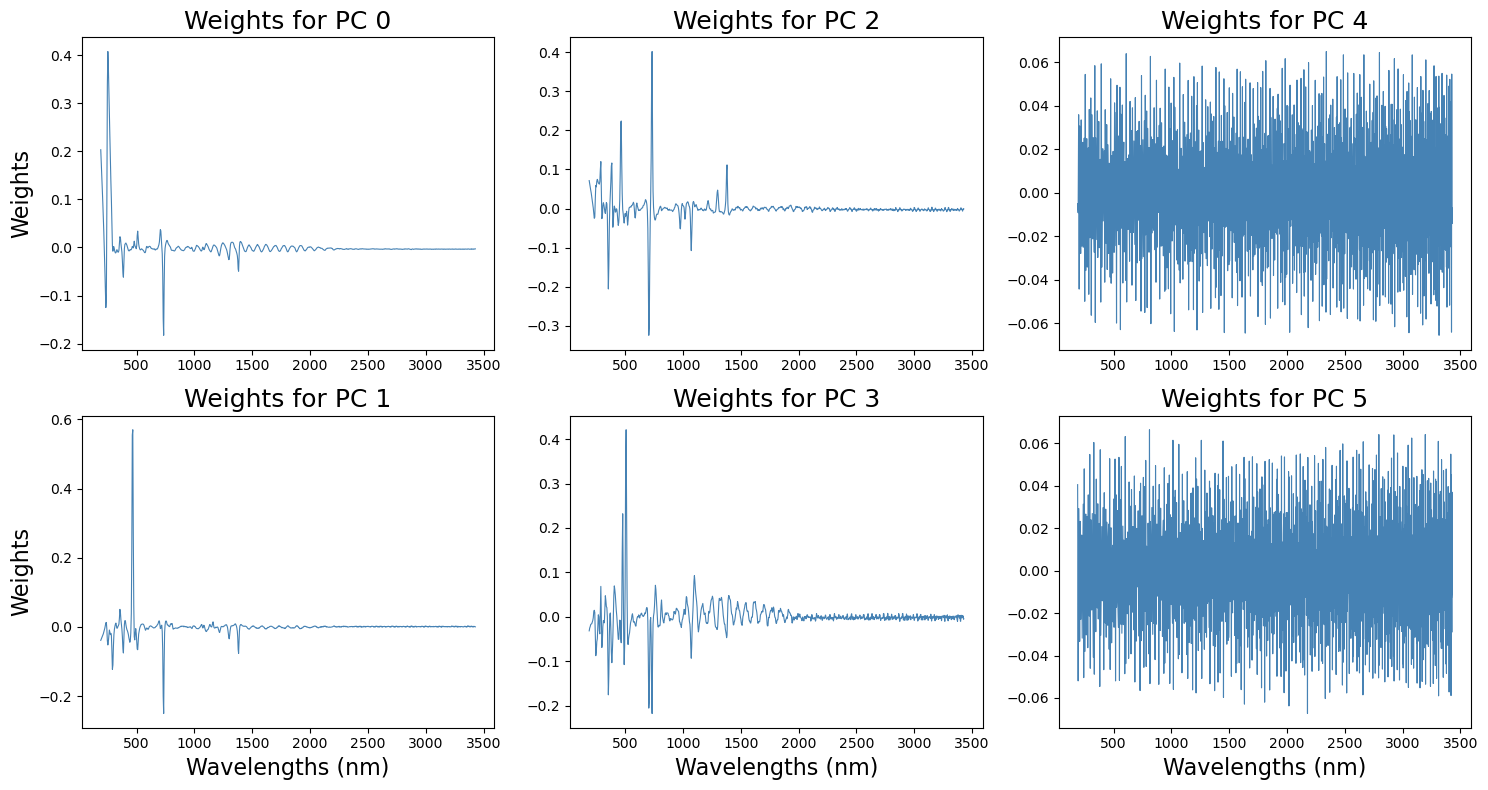

In [29]:
fig, ax = subplots(2, 3, figsize = (15, 8))

h, v = 0, 0

for i in range(principal_components.shape[-1]):
    axs = ax[h, v]
    axs.plot(wavelengths, weigths[i], color = 'steelblue', lw = 0.8)
    axs.set_title(f'Weights for PC {i}', fontsize = 18)
    axs.grid(False)

    if h == 1:
        axs.set_xlabel('Wavelengths (nm)', fontsize = 16) 
    if v == 0:
        axs.set_ylabel('Weights', fontsize = 16)
    
    h += 1
    if h == 2:
        v +=1
        h = 0

fig.tight_layout()

Reconstruction can be done as follows:

$$
\begin{align}
    PCA_{reconstruction} = PC_{scores} \cdot Eigenvectors^{T} + Mean
\end{align}
$$

In [30]:
reconstruction = np.dot(principal_components, weigths) + mu
reconstruction = reconstruction.reshape(spectrum.shape)